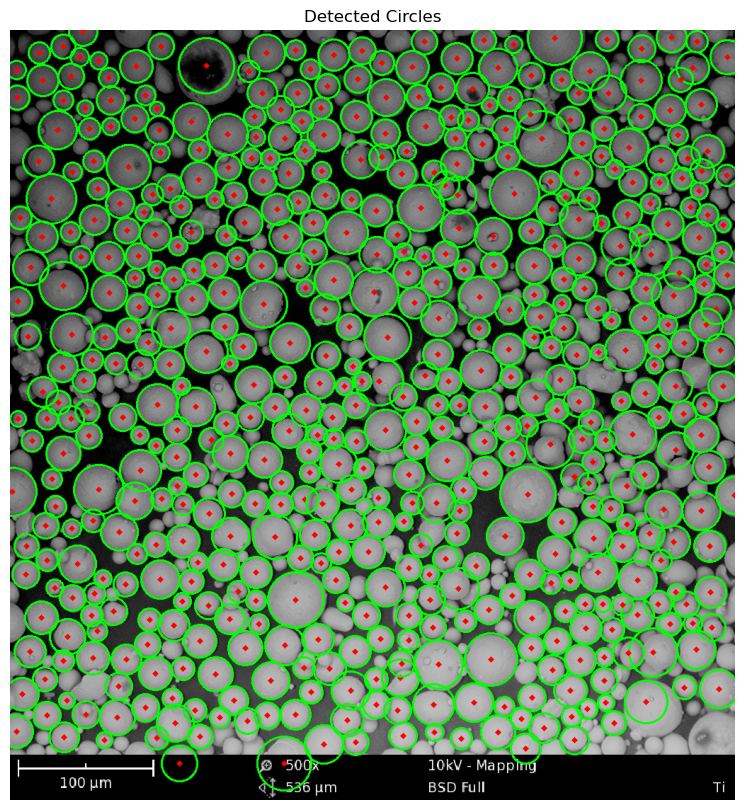

Saved 550 particles to 'particles_Ti' directory.


In [39]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

def detect_and_save_particles(filepath, 
                               output_dir="particles_Ti", 
                               minDist=20, 
                               param1=50, 
                               param2=30, 
                               minRadius=10, 
                               maxRadius=40, 
                               csv_filename="contour_coordinates.csv"):
    """
    Detect circles in an image using Hough Circle Transform and save cropped particle regions.
    Also saves the contour coordinates and particle filenames to a CSV file.

    Parameters:
        filepath (str): Path to the input image file.
        output_dir (str): Directory to save the detected particle crops.
        minDist (int): Minimum distance between the centers of detected circles.
        param1 (int): First method-specific parameter for cv2.HoughCircles (e.g., higher threshold for edge detection).
        param2 (int): Second method-specific parameter (e.g., accumulator threshold for circle detection).
        minRadius (int): Minimum radius of detected circles.
        maxRadius (int): Maximum radius of detected circles.
        csv_filename (str): The name of the CSV file to save contour coordinates and filenames.

    Returns:
        None
    """
    # Load the image
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Unable to load image at '{filepath}'.")
        return

    # Apply GaussianBlur to reduce noise
    img_blur = cv2.GaussianBlur(img, (9, 9), 2)

    # Apply Hough Circle Transform
    circles = cv2.HoughCircles(
        img_blur,
        cv2.HOUGH_GRADIENT,
        dp=1.2,
        minDist=minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius
    )

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Prepare to write the CSV file
    with open(csv_filename, mode="a", newline="") as file:
        writer = csv.writer(file)
        
        # If the CSV file is empty, write the header
        if file.tell() == 0:
            writer.writerow(["Particle Filename", "Center X", "Center Y", "Radius"])

        # Process and save detected circles
        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")

            for idx, (x, y, r) in enumerate(circles):
                # Crop the particle region with a square bounding box
                x1, y1 = max(x - r, 0), max(y - r, 0)
                x2, y2 = min(x + r, img.shape[1]), min(y + r, img.shape[0])

                particle_crop = img[y1:y2, x1:x2]

                # Save the cropped particle image
                particle_filename = f"particle_{idx + 1}.png"
                particle_path = os.path.join(output_dir, particle_filename)
                cv2.imwrite(particle_path, particle_crop)

                # Write the particle filename and contour coordinates to the CSV
                writer.writerow([particle_filename, x, y, r])

            # Visualize the detected circles on the original image
            output_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            for (x, y, r) in circles:
                # Draw the outer circle and the center of the circle
                cv2.circle(output_img, (x, y), r, (0, 255, 0), 2)
                cv2.circle(output_img, (x, y), 2, (0, 0, 255), 3)

            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
            plt.axis("off")
            plt.title("Detected Circles")
            plt.show()

            print(f"Saved {len(circles)} particles to '{output_dir}' directory.")
        else:
            print("No circles were detected.")

# Example usage:
detect_and_save_particles("SEM/Ti/Ti0015.jpg")


In [2]:
from PIL import Image
import os
import pandas as pd

def process_images_to_excel(input_folder, output_file='particles_data_Ti_scaled.xlsx', target_size=(50, 50)):
    """
    Process images in a folder: resize them, convert to grayscale, and save pixel data to an Excel file.

    Parameters:
        input_folder (str): Path to the folder containing images.
        output_file (str): Path to save the output Excel file.
        target_size (tuple): Target size for resizing images (width, height).

    Returns:
        pd.DataFrame: DataFrame containing file names, pixel data, and list lengths.
    """
    # Check if the folder exists
    if not os.path.exists(input_folder):
        raise FileNotFoundError(f"Folder '{input_folder}' not found.")

    # List to store data
    data = []

    # Iterate through all files in the folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.png'):
            file_path = os.path.join(input_folder, file_name)
            # Open the image and convert to grayscale
            with Image.open(file_path) as img:
                img = img.resize(target_size, Image.LANCZOS)  # Resize image
                img = img.convert('L')  # Convert to grayscale
                img_data = list(img.getdata())  # Flatten the pixel data
                # Append data to the list
                data.append({
                    'File Name': file_name,
                    'Pixel Data': img_data,
                    'List Length': len(img_data)
                })

    # Convert data to DataFrame
    df = pd.DataFrame(data)

    # Save DataFrame to Excel
    df.to_excel(output_file, index=False)

    print(f"Data successfully saved to file '{output_file}'")

    return df

# Example usage:
df = process_images_to_excel('particles_Ti', 'particles_data_Ti_scaled.xlsx', target_size=(50, 50))


Data successfully saved to file 'particles_data_Ti_scaled.xlsx'


In [11]:
import pandas as pd

def process_and_combine_particle_data(file1, file2='particles_data_with_length_aug_scaled.xlsx', 
                                      output_combined='particles_data_Ti_comb_scaled.xlsx', 
                                      output_extended='particles_data_Ti_comb_pixel_scaled.csv'):
    """
    Combine two particle datasets, process pixel data, and save an extended CSV with pixel columns.

    Parameters:
        file1 (str): Path to the first Excel file.
        file2 (str): Path to the second Excel file.
        output_combined (str): Path to save the combined Excel file.
        output_extended (str): Path to save the extended CSV file.

    Returns:
        pd.DataFrame: DataFrame containing the extended data.
    """
    # Load the Excel files
    df_Ti = pd.read_excel(file1)
    df_aug = pd.read_excel(file2) #labeled

    # Combine the DataFrames
    df_combined = pd.concat([df_Ti, df_aug], axis=0)
    df_combined.to_excel(output_combined, index=False)

    # Load the combined data
    data = pd.read_excel(output_combined)

    # Check if data exists
    if data.empty:
        raise ValueError("No data to process. Ensure the image files are available.")

    # Process Pixel Data
    for index, row in data.iterrows():
        # Convert Pixel Data from string to a list of integers
        pixel_data = row['Pixel Data'].strip(',')  # Remove trailing commas if any
        data.at[index, 'Pixel Data'] = [int(x) for x in pixel_data.split(',') if x.strip().isdigit()]

    # Find the maximum length of Pixel Data
    max_length = max(len(row) for row in data['Pixel Data'])

    # Prepare formatted data for the extended DataFrame
    formatted_data = []
    for index, row in data.iterrows():
        # Add row data, padding with zeros to match the max length
        flattened_row = [row['File Name']] + row['Pixel Data'] + [0] * (max_length - len(row['Pixel Data']))
        formatted_data.append(flattened_row)

    # Create column names: 'File Name' followed by 'Pixel_0', 'Pixel_1', ...
    column_names = ['File Name'] + [f'Pixel_{i}' for i in range(max_length)]

    # Convert to DataFrame
    formatted_df = pd.DataFrame(formatted_data, columns=column_names)

    # Save the extended data to CSV
    formatted_df.to_csv(output_extended, index=False)

    print(f"Data successfully saved to file '{output_extended}'")

    return formatted_df

#\ Example usage:
formatted_df = process_and_combine_particle_data(
     'particles_data_Ti_scaled.xlsx'
 )


Data successfully saved to file 'particles_data_Ti_comb_pixel_scaled.csv'


In [19]:
import pandas as pd
from sklearn.manifold import TSNE
import re

def process_tsne_and_label(input_csv, output_file_tsne='particles_data_Ti_comb_tSNE_3D_scaled.xlsx', output_file_labeled='particles_data_Ti_comb_tSNE_labeled_3D_scaled.xlsx'):
    """
    Process pixel data from a CSV, apply t-SNE dimensionality reduction, and add labels based on file names.

    Parameters:
        input_csv (str): Path to the input CSV file containing pixel data.
        output_file_tsne (str): Path to save the t-SNE reduced Excel file.
        output_file_labeled (str): Path to save the labeled Excel file.

    Returns:
        pd.DataFrame: DataFrame with t-SNE dimensions and labels.
    """
    # Load data from CSV
    data = pd.read_csv(input_csv)

    # Extract pixel columns
    pixel_columns = [col for col in data.columns if col.startswith('Pixel_')]
    pixel_data = data[pixel_columns]

    # Apply t-SNE for dimensionality reduction to 3D
    tsne = TSNE(n_components=3, random_state=42)
    tsne_result = tsne.fit_transform(pixel_data)

    # Create a new DataFrame with t-SNE results
    result_data = data.drop(columns=pixel_columns)  # Remove pixel data columns
    result_data['Dim_1'] = tsne_result[:, 0]
    result_data['Dim_2'] = tsne_result[:, 1]
    result_data['Dim_3'] = tsne_result[:, 2]

    # Save the t-SNE results to an Excel file
    result_data.to_excel(output_file_tsne, index=False)

    # Ensure 'File Name' column exists
    if 'File Name' not in result_data.columns:
        raise ValueError("Column 'File Name' not found in the data.")

    # Add a 'label' column by extracting a substring between underscores and before 'cropped'
    def extract_label(file_name):
        if isinstance(file_name, str):
            cleaned_name = re.sub(r'png_parts_', '', file_name)
            match = re.search(r'_(.*?)_cropped', cleaned_name)
            return match.group(1) if match else None
        return None

    result_data['label'] = result_data['File Name'].apply(extract_label)

    # Add a 'metal' column by extracting the substring after the last backslash and before the first underscore
    def extract_metal(file_name):
        if isinstance(file_name, str):
            match = re.search(r'\\(.*?)_', file_name)
            return match.group(1) if match else None
        return None

    result_data['metal'] = result_data['File Name'].apply(extract_metal)

    # Save the labeled data to another Excel file
    result_data.to_excel(output_file_labeled, index=False)

    print(f"t-SNE data saved to '{output_file_tsne}'")
    print(f"Labeled data saved to '{output_file_labeled}'")

    return result_data

# Example usage:
df_labeled = process_tsne_and_label('particles_data_Ti_comb_pixel_scaled.csv')

t-SNE data saved to 'particles_data_Ti_comb_tSNE_3D_scaled.xlsx'
Labeled data saved to 'particles_data_Ti_comb_tSNE_labeled_3D_scaled.xlsx'


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def process_pca(input_csv, output_csv='particles_data_Ti_comb_pixel_pca50.csv', 
                n_components=50, labels = 'particles_data_Ti_comb_tSNE_labeled_3D_scaled.xlsx'):
    """
    Apply PCA on pixel data to reduce dimensionality and save the result to a CSV file.

    Parameters:
        input_csv (str): Path to the input CSV file containing pixel data.
        output_csv (str): Path to save the CSV file with reduced PCA components.
        n_components (int): Number of PCA components to retain.

    Returns:
        pd.DataFrame: DataFrame with reduced PCA components and additional labels.
    """
    # Load data from CSV
    df = pd.read_csv(input_csv)

    # Select all columns containing 'Pixel_' in their names
    pixel_columns = [col for col in df.columns if 'Pixel_' in col]

    # Extract pixel data
    pixel_data = df[pixel_columns]

    # Standardize the pixel data
    scaler = StandardScaler()
    pixel_data_scaled = scaler.fit_transform(pixel_data)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=n_components)
    pixel_data_pca = pca.fit_transform(pixel_data_scaled)

    # Create a new DataFrame with PCA results
    pca_columns = [f'PCA_Component_{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(pixel_data_pca, columns=pca_columns)

    # Combine with original data, excluding old Pixel_ columns
    df_reduced = pd.concat([df.drop(columns=pixel_columns), pca_df], axis=1)

    # Ensure 'label' and 'metal' columns are included if they exist
    #if 'label' in df.columns:
    labels = pd.read_excel('particles_data_Ti_comb_tSNE_labeled_3D_scaled.xlsx')
    df_reduced['label'] = labels['label']
    #if 'metal' in df.columns:
    df_reduced['metal'] = labels['metal']

    # Save the reduced DataFrame to CSV
    df_reduced.to_csv(output_csv, index=False)

    print(f"Reduced data saved to '{output_csv}'")

    return df_reduced

# Example usage:
df_pca = process_pca('particles_data_Ti_comb_pixel_scaled.csv')


Reduced data saved to 'particles_data_Ti_comb_pixel_pca50.csv'


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

def train_and_predict_with_label_encoding(input_csv, output_xlsx, label_mapping_csv, test_size=0.15, random_state=42):
    """
    Train an XGBoost model on labeled data, encode and decode labels, predict labels for unlabeled data, and save the results.

    Parameters:
        input_csv (str): Path to the input CSV file containing PCA components and labels.
        output_csv (str): Path to save the CSV file with predicted labels for unlabeled data.
        label_mapping_csv (str): Path to save the label encoding mapping.
        test_size (float): Proportion of data to use as a test set.
        random_state (int): Random seed for reproducibility.

    Returns:
        tuple: (accuracy, f1_score, DataFrame with predicted labels for unlabeled data)
    """
    # Load reduced data
    df_reduced = pd.read_csv(input_csv)
    
    # Filter labeled data for training
    df_train = df_reduced[df_reduced['label'].notna()]

    # Encode labels using LabelEncoder
    label_encoder = LabelEncoder()
    df_train['label_encoded'] = label_encoder.fit_transform(df_train['label'])

    # Save label mapping to a CSV file
    label_mapping = pd.DataFrame({
        'label': label_encoder.classes_,
        'encoded_label': range(len(label_encoder.classes_))
    })
    label_mapping.to_csv(label_mapping_csv, index=False)

    # Define features (X) and target (Y)
    X = df_train[[col for col in df_train.columns if 'PCA_Component_' in col]]
    Y = df_train['label_encoded']

    # Split the data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state, stratify=Y
    )

    # Initialize the XGBoost model
    model = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

    # Train the model
    model.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)

    # Predict labels for unlabeled data
    df_new = df_reduced[df_reduced['label'].isna()]
    X_new = df_new[[col for col in df_reduced.columns if 'PCA_Component_' in col]]
    Y_new_encoded = model.predict(X_new)

    # Decode predicted labels
    Y_new = label_encoder.inverse_transform(Y_new_encoded)
    df_new['label'] = Y_new
    df_new = df_new.drop(columns=[col for col in df_new.columns if 'PCA_Component_' in col])
    df_new = df_new.drop(columns=['metal'])
    # Save the new data with predicted labels
    df_new.to_excel(output_xlsx, index=False)

    print(f"Predicted labels saved to '{output_xlsx}'")

    return accuracy, f1, df_new

# Example usage:
accuracy, f1, df_labeled = train_and_predict_with_label_encoding(
     'particles_data_Ti_comb_pixel_pca50.csv', 
     'particles_new_data_Ti_comb_labeled.xlsx',
     'label_mapping.csv')


C:\Users\ivan\AppData\Local\Temp\ipykernel_12600\655557655.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['label_encoded'] = label_encoder.fit_transform(df_train['label'])
D:\Users\ivan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.6837606837606838
F1 Score: 0.6874610920291984
Predicted labels saved to 'particles_new_data_Ti_comb_labeled.xlsx'


C:\Users\ivan\AppData\Local\Temp\ipykernel_12600\655557655.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['label'] = Y_new


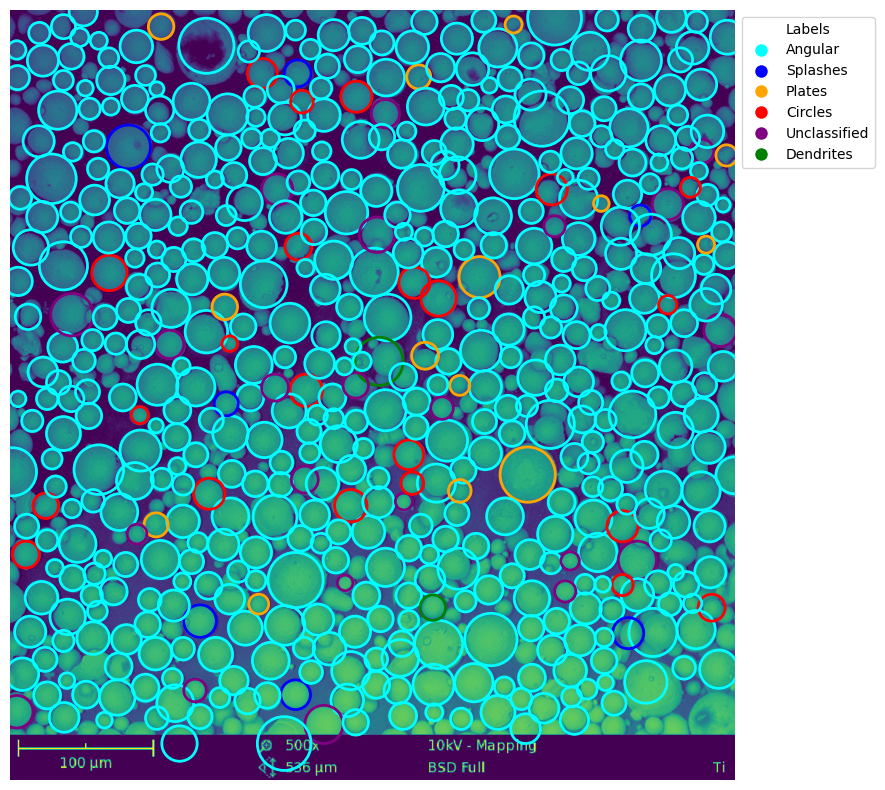

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Load data from CSV and Excel files
coordinates_df = pd.read_csv('contour_coordinates.csv')  # Coordinates and radius
labels_df = pd.read_excel('particles_new_data_Ti_comb_labeled.xlsx')  # Labels

# Define a mapping for labels
label_mapping = {
    'bryzgi': 'Splashes',
    'dendr': 'Dendrites',
    'krug': 'Circles',
    'nekclass': 'Unclassified',
    'plast': 'Plates',
    'uglov': 'Angular'
}

# Update the labels in the DataFrame
labels_df['label'] = labels_df['label'].map(label_mapping)

# Check if both dataframes have the same number of entries
if len(coordinates_df) != len(labels_df):
    print(f"Warning: The number of coordinates ({len(coordinates_df)}) does not match the number of labels ({len(labels_df)}).")
    # Optionally, you can trim the larger dataframe to match the smaller one
    min_len = min(len(coordinates_df), len(labels_df))
    coordinates_df = coordinates_df.iloc[:min_len]
    labels_df = labels_df.iloc[:min_len]

# Define a color mapping for the unique labels
label_color_map = {
    'Splashes': 'blue',
    'Dendrites': 'green',
    'Circles': 'red',
    'Unclassified': 'purple',
    'Plates': 'orange',
    'Angular': 'cyan'
}

# Load the image
image = Image.open("SEM/Ti/Ti0015.jpg")

# Plot the image
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size for better visualization
ax.imshow(image)

# Create a list to store legend entries
legend_entries = []

# Iterate over the data and plot circles
for i, row in coordinates_df.iterrows():
    center_x = row['Center X']
    center_y = row['Center Y']
    radius = row['Radius']
    
    # Get the label and corresponding color
    label = labels_df['label'].iloc[i]
    color = label_color_map.get(label, 'gray')  # Default to 'gray' if label is unknown

    # Draw the circle on top of the image
    circle = plt.Circle((center_x, center_y), radius, color=color, fill=False, linewidth=2)
    ax.add_artist(circle)

    # Add the label to the legend
    if label not in [entry[0] for entry in legend_entries]:
        legend_entries.append((label, color))

# Add the legend outside the image
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
           for label, color in legend_entries]
ax.legend(handles=handles, title='Labels', loc='upper left', bbox_to_anchor=(1, 1))  # Move legend outside

# Display the plot without axis
plt.axis('off')

# Adjust layout to make room for the legend outside
plt.tight_layout()

# Show the image with circles and the external legend
plt.savefig('Ti_labeled.png')
plt.show()
